# Fine Tuning A BERT Model With HuggingFace

## 1. Introduction

In [2]:
# !pip install arxiv
# !pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00


 Next I authenticate myself as my Google account user. This will be helpful since I will be storing the documents as json in [Google Cloud Storage](https://cloud.google.com/storage?hl=en). Authentication through [colab](https://colab.research.google.com/) means there's no extra steps or API keys for me to access the data!

In [3]:
import google.colab as colab
colab.auth.authenticate_user()

## 2. Collecting The Data

The first thing I need to do is collect data. In a [prior post](https://michael-harmon.com/blog/NLP1.html) I got documents for classification by collecting paper abstracts from [arxiv](https://arxiv.org/). I was going to reuse those same documents, but over the years I lost them. So, instead I'll use the [arixv package](https://lukasschwab.me/arxiv.py/arxiv.html) to create a new dataset for classification. Instead of 4 classes I'll use 3 and still make the datasets imbalanced. The 3 classes I'll use are the topics of the papers which I chose to be 'Artificial Intelligence', 'Information Retrieval' and 'Robotics'.

First I collect 1,000 papers on 'Ariticial Intelligence', 1,000 papers on 'Information Retrieval' and 100 on 'Robotics' using a function I wrote called [get_data](utils.py).

In [ ]:
from utils import get_arxiv_data

df = get_arxiv_data

Now looking at the contents of the dataframe,

In [ ]:
df.head(2)

,id,code,text
0,http://arxiv.org/abs/cs/9308101v1,cs.AI,Because of their occasional need to return to ...
1,http://arxiv.org/abs/cs/9308102v1,cs.AI,Market price systems constitute a well-underst...


In the above results the `id` is the url of the paper, the `code` is the class label and `text` is the abstract of the paper.

I want to be able to predict the category of the abstract based of the text. This means we need to convert the category into a numerical value. [Scikit-learn's LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) is the tool for the job,

In [ ]:
from sklearn.preprocessing import LabelEncoder

labeler  = LabelEncoder()
df = df.assign(label=labeler.fit_transform(df["code"]))

Now each text has an associated numerical value in the column `label` with values based on the `code` value,

In [ ]:
df.head(2)

,id,code,text,label
0,http://arxiv.org/abs/cs/9308101v1,cs.AI,Because of their occasional need to return to ...,0
1,http://arxiv.org/abs/cs/9308102v1,cs.AI,Market price systems constitute a well-underst...,0


The numerical value for each code is given by the order in the `classes_` attribute of the labler. This means mapping between the code and the label can be found by the following,

In [ ]:
{v:k for k,v in enumerate(labeler.classes_)}

{'cs.AI': 0, 'cs.IR': 1, 'cs.RO': 2}

Next I need to break the datasets into train, validation and test sets. I can do this with [Scikit-Learn's train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                            df["text"],
                                            df["label"],
                                            test_size=0.15,
                                            random_state=42,
                                            stratify=df["label"])

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.20,
                                                  random_state=42,
                                                  stratify=y_train)

The size of the datsets are,

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((1428,), (357,), (315,))

These are small datasets, but luckily using finetuning we can still build a high performance model! I know that Scikit-Learn uses stratified sampling by default, but I'll still check to make sure the distribution of class labels is consistent between the train, validation and test sets.

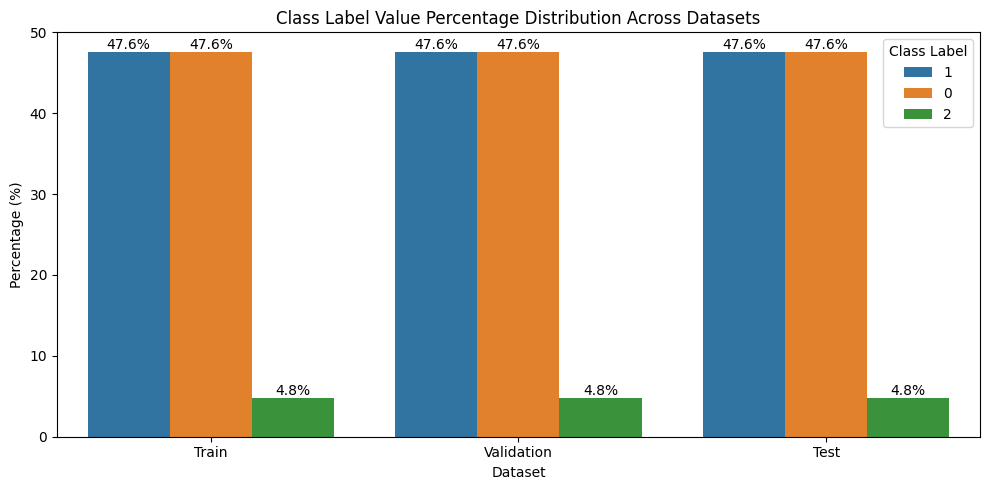

In [ ]:
from utils import plot_target_distribution_combined
plot_target_distribution_combined(train_df, val_df, test_df)

We can see that it distribution of classes across each dataset is consistent. The last thing to do before modeling is combine `X` and `y` back into one dataframe and save them to [Google Cloud Storage](https://cloud.google.com/storage?hl=en). This is necessary so I can come back to this project over time and still work with the same data.

In [ ]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
train_df.to_json("gs://harmon-arxiv/train_abstracts.json")

val_df   = pd.DataFrame({"text": X_val, "label": y_val})
val_df.to_json("gs://harmon-arxiv/val_abstracts.json")

test_df =  pd.DataFrame({"text": X_test, "label": y_test})
test_df.to_json("gs://harmon-arxiv/test_abstracts.json")

## 2. HuggingFace Datasets & Models

Now that I have the data in [Google Cloud Storage](https://cloud.google.com/storage?hl=en) we begin the fine tuning of our model. Since this is a classification problem I'll use a [Encoder model](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)); specifically a Bidirectional Encoder Representations from Transformers [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) model. BERT's architecture is pictured below,

<figure>
<img src="https://github.com/mdh266/FineTuning/blob/main/images/bert.png?raw=1" alt="BERT" width="400" height="600" class="center">
<figcaption>BERT Encoder Architecture
</figure>

I wont go over much about Encoders and Transformers as the internet has plently of good material. I found [Andrew Ng's Sequence Models](https://www.coursera.org/learn/nlp-sequence-models/paidmedia?specialization=deep-learning) course along with the [100 Page Large Language Models Book](https://www.thelmbook.com/) very helpful in understanding transformers. Instead, this post will focus on how to fine tune a BERT model for text classification using the [Hugging Face API](https://huggingface.co/). I have heard of Hugging Face for years, but never fully understood what it was. I am currently making my way through the [Hugging Face LLM Course](https://huggingface.co/learn/llm-course/chapter1/1) and figured I would solidify my learnings by writing this post. Hugging Face is an open-soure platform and api for building and sharing artificial intelligence models (as well as datasets to buildt them). It is frequently called the "Git Hub" of AI models. With the API you can very easily download a pre-trained model, fine tune for your problem and the push it back to their "Model Hub" where others in the community can use it. And I'll be doing just that in this post! The last thing I'll say about Hugging Face is that the Python library works as a high level wrapper around deep learning frameworks such as [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/) and [JAX](https://docs.jax.dev/en/latest/).

The first thing I do is import Pandas (to reload the data from cloud storage) as well as the necessary [PyTorch](https://pytorch.org/) and Hugging Face modules.

In [4]:
import pandas as pd

# PyTorch imports
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

# Hugging Face imports
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
import evaluate

Now I can load the datasets from cloud storage as Pandas dataframes,

In [5]:
train_df = pd.read_json("gs://harmon-arxiv/train_abstracts.json")
val_df = pd.read_json("gs://harmon-arxiv/val_abstracts.json")
test_df = pd.read_json("gs://harmon-arxiv/test_abstracts.json")

and then convert them to [Hugging Face Datasets](https://huggingface.co/docs/datasets/en/index) so they can be used by the Hugging Face model:

In [6]:
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

Finally I will combine them into a [DatasetDict](https://huggingface.co/docs/datasets/v4.0.0/en/package_reference/main_classes#datasets.DatasetDict) obect. This is not necessary, but it is convenient since applying a transformation to the DatasetDict applies it all the Datasets. This avoids repeating the same transformations individually across each dataset individually.

In [7]:
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

Next I download the [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) model from [HuggingFace's Model Hub](https://huggingface.co/models) as well as its associated [Tokenizer](https://huggingface.co/docs/transformers/en/main_classes/tokenizer). To do so, I use the [AutoTokenizer and AutoModelForSequenceClassification classes](https://huggingface.co/docs/transformers/en/model_doc/auto) as they allow me to swap out models easily. Notice that the tokenizer has to match the model and we have to use the [from_pretrained class methods](https://www.geeksforgeeks.org/python/classmethod-in-python/) for each class. This ensures that the tokenizer and weights for the model are both initialized from the same point in pre-training.


Lastly, notice move the model to the GPU and that I have to put the number of classes in AutoModelForSequenceClassification during instantiation. This adds a linear layer with softmax on top of the foundational model.

In [8]:
checkpoint = "google-bert/bert-base-uncased"
device="cuda"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Note that the tokenizer here is not a word level tokenization like I have used in [prior blog posts](https://michael-harmon.com/blog/NLP1.html) that have used the [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model. Instead it uses a [sub-word tokenization method](https://huggingface.co/learn/llm-course/chapter6/6?fw=pt). The [100 Page Large Language Models Book](https://www.thelmbook.com/) had a good explanation on this topic, albiet it focused on Byte-Pair Encoding tokenization while BERT uses a WordPiece tokenization.

I can see that the model I have downloaded is a BERT MMdel by looking at its type:

```
type(model)
```

it returns,

```
transformers.models.bert.modeling_bert.BertForSequenceClassification
```

and
```
print(model)
```

which will return,


```
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=768, out_features=3, bias=True)
)
```

The "classifier" layer (aka the "classification head") is the linear that was added to the model when I downloaded it. The `out_features` parameter that shows the output has 3 classes.

Now I can tokenizer the datsets by creating a `tokenize_function` and applying it to the DataDict with the `map` method.

In [9]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/1428 [00:00<?, ? examples/s]

Map:   0%|          | 0/357 [00:00<?, ? examples/s]

Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Notice that I have the parameter `batched=True`, however, we have not used any padding. I will use [Dynamic Padding](https://huggingface.co/learn/llm-course/en/chapter3/2#dynamic-padding) which will determine the maximum length of documents per batch. The maximum length of documents will determine the amount of padding to be used at a batch level. If I did not use batching with Dynamic Padding all batches would have to be read in to determine the length of the longest document to determine padding size for each document. In my case, this is not such a big deal since the dataset is already in memory, but when reading from disk it can be helpful.

To use Dynamic Padding I use the [DataCollatorWithPadding](https://huggingface.co/docs/transformers/en/main_classes/data_collator) class:

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

This will be used later on during training since it's just adding 0's at the beginning or end of the tokenized vector (`token_ids`) within each batch. I can see the schema of the datasets by looking at the columns:

```
tokenized_datasets["test"].features

```

```
{'text': Value('string'),
 'label': Value('int64'),
 'input_ids': List(Value('int32')),
 'token_type_ids': List(Value('int8')),
 'attention_mask': List(Value('int8'))}
 ```

HuggingFace requires that the datasets only have the following columns:

* `labels`: The class for the text.

* `input_ids`: Vector of integers for the numerical representation of tokenized.
  
* `attention_mask`: List of 0's or 1's for the model to infer if it should "attend" to this token in the attention mechanism.

In order to get the dataset to meet this requirements I will drop the "text" column and rename the "label" column to "labels",

In [11]:
tokenized_datasets = tokenized_datasets.remove_columns("text")
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

Since I will be using [PyTorch](https://pytorch.org/) as a backend I have to convert the arrays in the datasets into PyTorch tensors.

In [12]:
tokenized_datasets = tokenized_datasets.with_format("torch")

Lastly, I can confirm the schema and size of the datsets,

```
print(tokenized_datasets["test"].features)

{'labels': Value('int64'),
'input_ids': List(Value('int32')),
'token_type_ids': List(Value('int8')),
'attention_mask': List(Value('int8'))}
```
and the size of the datasets
```
print(tokenized_datasets.num_rows)

{'train': 1428, 'validation': 357, 'test': 315}
```

## 3. Fine Tuning BERT






In [13]:
from huggingface_hub import notebook_login
notebook_login()


I chose a multiclass [ROC-AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) metric to measure the perofrmance of the model. This is a pretty standard metric for classification problems since it in essence measures "how well the model call separate the classes." Though it should be noted the ROC-AUC curve can be misleading when you have imbalanced classes as I discussed in a [prior post](https://michael-harmon.com/blog/NLP1.html).

In order to use metrics to evaluate the performance of Hugging Face models users must use the [evaluate](https://huggingface.co/docs/evaluate/en/index) library from Hugging Face. I use the [one vs. rest multi-class ROC-AUC](https://huggingface.co/spaces/evaluate-metric/roc_auc). In order to pass it into the Hugging Face fine tunning library I have to define the following function:

In [14]:
from typing import Tuple
import numpy as np

def compute_metrics(eval_preds):
    roc_auc_score = evaluate.load("roc_auc", "multiclass")
    preds, labels = eval_preds
    scores = torch.nn.functional.softmax(torch.tensor(preds), dim=-1)

    return roc_auc_score.compute(prediction_scores=scores, references=labels, multi_class="ovr")

In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id="mdh266/arxivist",
    report_to="none"
)

In [17]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)


In [18]:
output = trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,0.403200,0.385415,0.977273
2,0.227000,0.364516,0.976224
3,0.139600,0.458447,0.966614
4,0.073900,0.423210,0.980586
5,0.035400,0.429581,0.979789


In [20]:
tokenizer = trainer.processing_class
tokenizer.push_to_hub("mdh266/arxivist")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/mdh266/arxivist/commit/4e45e2a3921583fae8d089aa1a0aaa6651407077', commit_message='Upload tokenizer', commit_description='', oid='4e45e2a3921583fae8d089aa1a0aaa6651407077', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mdh266/arxivist', endpoint='https://huggingface.co', repo_type='model', repo_id='mdh266/arxivist'), pr_revision=None, pr_num=None)

In [21]:
model = trainer.model

In [23]:
model.config.label2id = {v:k for k,v in enumerate(['Artificial Intelligence','Information Retrieval', 'Robotics'])}
model.config.id2label = {k:v for k,v in enumerate(['Artificial Intelligence','Information Retrieval', 'Robotics'])}
model.push_to_hub("mdh266/arxivist")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpj9ee0m08/model.safetensors    :  10%|9         | 41.9MB /  438MB            

CommitInfo(commit_url='https://huggingface.co/mdh266/arxivist/commit/c34b2c4019d66989e8cf04c3512af4bf655e2138', commit_message='Upload BertForSequenceClassification', commit_description='', oid='c34b2c4019d66989e8cf04c3512af4bf655e2138', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mdh266/arxivist', endpoint='https://huggingface.co', repo_type='model', repo_id='mdh266/arxivist'), pr_revision=None, pr_num=None)

In [1]:
model

NameError: name 'model' is not defined

In [2]:
from transformers import pipeline

In [5]:
classifier = pipeline("text-classification", model="mdh266/arxivist")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/903 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [19]:
# https://arxiv.org/abs/2508.05557
text = "Social media has evolved into a complex multimodal environment where text, images, and other signals interact to shape nuanced meanings, often concealing harmful intent. Identifying such intent, whether sarcasm, hate speech, or misinformation, remains challenging due to cross-modal contradictions, rapid cultural shifts, and subtle pragmatic cues. To address these challenges, we propose MV-Debate, a multi-view agent debate framework with dynamic reflection gating for unified multimodal harmful content detection. MV-Debate assembles four complementary debate agents, a surface analyst, a deep reasoner, a modality contrast, and a social contextualist, to analyze content from diverse interpretive perspectives. Through iterative debate and reflection, the agents refine responses under a reflection-gain criterion, ensuring both accuracy and efficiency. Experiments on three benchmark datasets demonstrate that MV-Debate significantly outperforms strong single-model and existing multi-agent debate baselines. This work highlights the promise of multi-agent debate in advancing reliable social intent detection in safety-critical online contexts."

In [20]:
classifier(text)

[{'label': 'Artificial Intelligence', 'score': 0.9789971709251404}]

In [17]:
# https://arxiv.org/abs/2508.05633
text = "Live streaming platforms have become a dominant form of online content consumption, offering dynamically evolving content, real-time interactions, and highly engaging user experiences. These unique characteristics introduce new challenges that differentiate live streaming recommendation from traditional recommendation settings and have garnered increasing attention from industry in recent years. However, research progress in academia has been hindered by the lack of publicly available datasets that accurately reflect the dynamic nature of live streaming environments. To address this gap, we introduce KuaiLive, the first real-time, interactive dataset collected from Kuaishou, a leading live streaming platform in China with over 400 million daily active users. The dataset records the interaction logs of 23,772 users and 452,621 streamers over a 21-day period. Compared to existing datasets, KuaiLive offers several advantages: it includes precise live room start and end timestamps, multiple types of real-time user interactions (click, comment, like, gift), and rich side information features for both users and streamers. These features enable more realistic simulation of dynamic candidate items and better modeling of user and streamer behaviors. We conduct a thorough analysis of KuaiLive from multiple perspectives and evaluate several representative recommendation methods on it, establishing a strong benchmark for future research. KuaiLive can support a wide range of tasks in the live streaming domain, such as top-K recommendation, click-through rate prediction, watch time prediction, and gift price prediction. Moreover, its fine-grained behavioral data also enables research on multi-behavior modeling, multi-task learning, and fairness-aware recommendation."

In [18]:
classifier(text)

[{'label': 'Information Retrieval', 'score': 0.9845426082611084}]

In [ ]:
testset_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

In [ ]:
def calculate_roc_auc(model, loader: DataLoader) -> Dict[str, np.float64]:

  roc_auc_score = evaluate.load("roc_auc", "multiclass")
  model.eval()
  for batch in loader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)
          scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
          roc_auc_score.add_batch(references=batch["labels"],
                                prediction_scores=scores)

  return roc_auc_score.compute(multi_class="ovr")

In [ ]:
calculate_roc_auc(model, test_dataloader)

{'roc_auc': np.float64(0.972989898989899)}